In [1]:
#from mpl_toolkits import mplot3d
import pandas as pd
from numpy import array
import numpy as np
import h5py
import mplcursors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,

    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "computer-modern-roman",

    "figure.dpi": 300,
    "savefig.dpi": 300,
})


CMAPS = plt.colormaps
CMAP = CMAPS['hsv']

h = 0.6774  # co-moving constant


In [2]:


dat = h5py.File('global_sample_data_snapshot_1200.hdf5')

# for x in dat.values():
#     try:
#         list(x)
#     except:
#         print(x)
#         raise
dat = pd.DataFrame((list(x) for x in dat.values() if x.shape != ()), index=(
    k for k in dat.keys() if dat[k].shape != ())).transpose()


In [3]:
dat['is_satellite'] = dat['groupID'] != -1

dat.loc[dat['is_satellite'] == False, 'plot_shape'] = 'o'
dat.loc[dat['is_satellite'], 'plot_shape'] = '^'

for mu in 'X', 'Y', 'Z':
    dat[f'{mu}_Mpc_ahf_cat'] = dat[f'{mu}c_ahf_cat'] / h

s_filt = dat['groupID'] != -1
h_filt = dat['groupID'] == -1

In [46]:
list(dat.columns)


['Mgas_ahf_cat',
 'Mstar_ahf_cat',
 'Mvir_ahf_cat',
 'Redge',
 'Redge_ahf',
 'Rvir',
 'Rvir_ahf',
 'Rvir_ahf_cat',
 'Xc_ahf_cat',
 'Yc_ahf_cat',
 'Zc_ahf_cat',
 'dm_mass_within_r30_dm',
 'dm_mass_within_r30_dm_ahf',
 'dm_mass_within_r30_gas',
 'dm_mass_within_r30_gas_ahf',
 'dm_mass_within_r30_stars',
 'dm_mass_within_r30_stars_ahf',
 'dm_mass_within_r50_dm',
 'dm_mass_within_r50_dm_ahf',
 'dm_mass_within_r50_gas',
 'dm_mass_within_r50_gas_ahf',
 'dm_mass_within_r50_stars',
 'dm_mass_within_r50_stars_ahf',
 'dm_mass_within_r80_dm',
 'dm_mass_within_r80_dm_ahf',
 'dm_mass_within_r80_gas',
 'dm_mass_within_r80_gas_ahf',
 'dm_mass_within_r80_stars',
 'dm_mass_within_r80_stars_ahf',
 'galaxyID',
 'gas_mass_within_r30_dm',
 'gas_mass_within_r30_dm_ahf',
 'gas_mass_within_r30_gas',
 'gas_mass_within_r30_gas_ahf',
 'gas_mass_within_r30_stars',
 'gas_mass_within_r30_stars_ahf',
 'gas_mass_within_r50_dm',
 'gas_mass_within_r50_dm_ahf',
 'gas_mass_within_r50_gas',
 'gas_mass_within_r50_gas_ahf',

In [6]:
filt = dat['stars_mass_within_r50_stars'] < 1e9

m, b = np.polyfit(
    dat[filt]['stars_mass_within_r50_stars_ahf'],
    dat[filt]['r50_stars_ahf'],
    deg=1
)

# polynomial
x = np.linspace(1e6, 1e9, 100)
y = m*x+b

lin_fit = (x, y)


In [41]:
filt = dat['stars_mass_within_r50_stars'] < 1e9

m, b = np.polyfit(
    np.log(dat[filt]['stars_mass_within_r50_stars_ahf']),
    np.log(dat[filt]['r50_stars_ahf'] / h),
    deg=1,
)

x = np.linspace(13, 25, dat[filt].shape[0],
                dtype=np.float64)

y = m*x + b

pwr_fit = x, y

dat['beta_r50'] = (
    np.log(dat['r50_stars_ahf'] / h)
    - (m * np.log(dat['stars_mass_within_r50_stars_ahf']) + b)
)

np.mean(dat[filt]['beta_r50']), np.std(dat[filt]['beta_r50'])

c:\Users\MkZee\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-6.173289990394284e-16, 0.27575817229976585)

In [12]:
def sates(arr):
    return np.fromiter((n for i, n in enumerate(arr) if dat['groupID'][i] != -1), dtype=float)


def hosts(arr):
    return np.fromiter((n for i, n in enumerate(arr) if dat['groupID'][i] == -1), dtype=float)

def norm(arr: np.ndarray) -> np.ndarray:
    return arr / arr.max()


m_dict = {
    'Hosts': (dat[dat['is_satellite'] == False]),
    'Satellites': (dat[dat['is_satellite'] == True])
}


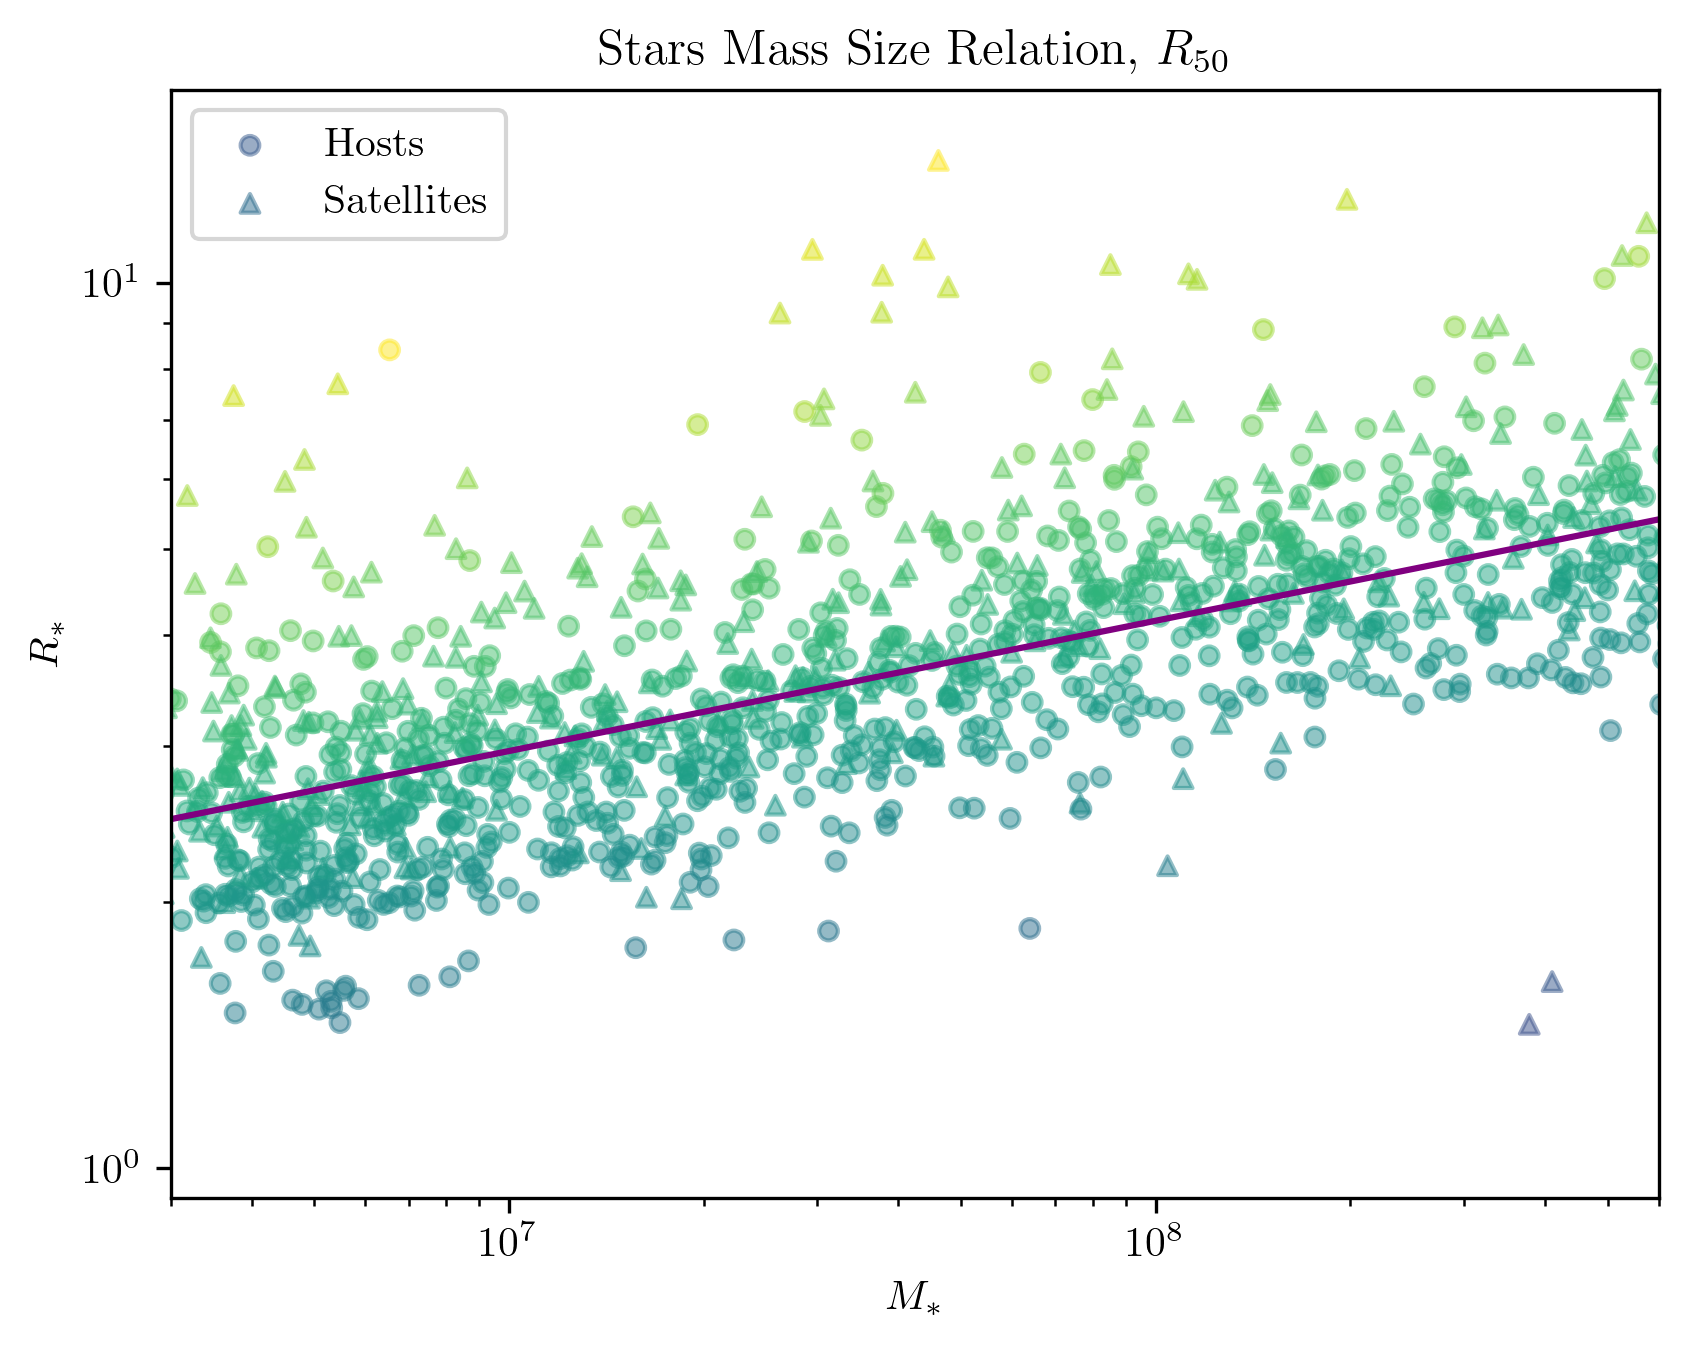

In [9]:
# BAD PLOT


fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_yscale('log'
for mark, d in zip(('o', '^'), m_dict.values()):
    mask = d['log_power_regression_r50'] > -np.inf  # no mask
    x, y = d[mask]['stars_mass_within_r50_stars_ahf'], d[mask]['r50_stars_ahf']
    ax.scatter(x, y, alpha=0.5, s=20, marker=mark,
               c=d[mask]['log_power_regression_r50'])


# ax.plot(*lin_fit)
ax.plot(*pwr_fit, color='purple')
#ax.scatter(sates(x), sates(y), alpha=0.5, s=5)
ax.set_xlim(3e6, 6e8)
#ax.set_ylim(1e6, 6e9)
ax.legend(tuple(m_dict))
ax.set_title(r'Stars Mass Size Relation, $R_{50}$')
ax.set_xlabel(r'$M_{*}$')
ax.set_ylabel(r'$R_{*}$')
fig.savefig('out.pgf')


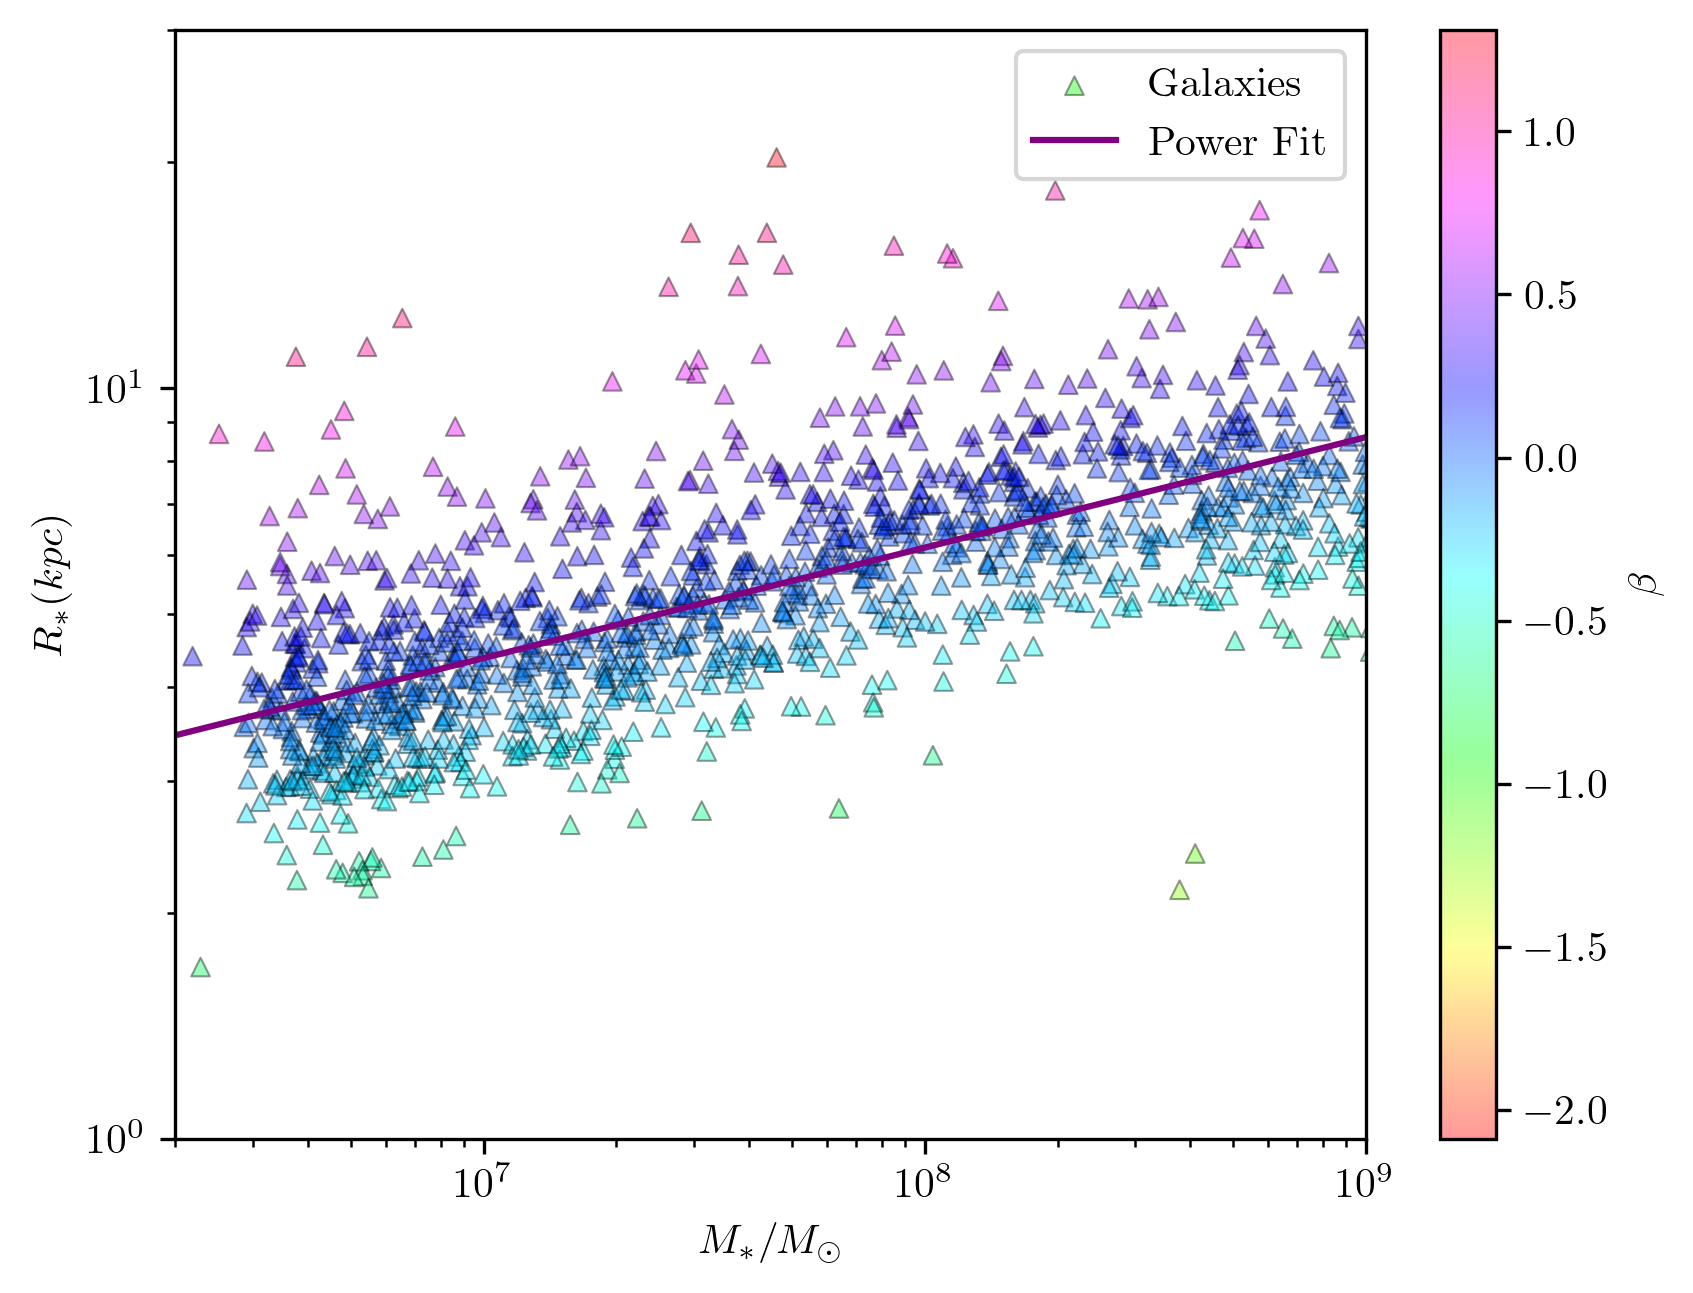

In [43]:

fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

d = dat
mask = d['beta_r50'] > -np.inf  # no mask
x, y = d[mask]['stars_mass_within_r50_stars_ahf'], d[mask]['r50_stars_ahf'] / h

_m = ax.scatter(x, y, alpha=0.4, s=20, marker='^',
                cmap=CMAPS['hsv'], c=d[mask]['beta_r50'], edgecolor='black', linewidth=0.5,
                )
fig.colorbar(_m, ax=ax).set_label(r'$\beta$')

# ax.plot(*lin_fit)
ax.plot(np.exp(pwr_fit[0]), np.exp(pwr_fit[1]), color='purple')
#ax.scatter(sates(x), sates(y), alpha=0.5, s=5)
ax.set_xlim(2e6, 1e9)
ax.set_ylim(1e0, 3e1)
ax.legend(('Galaxies', 'Power Fit'))
# ax.set_title(r'Stars Mass Size Relation, $R_{50}$')
ax.set_xlabel(r'$M_{*} / M_\odot$')
ax.set_ylabel(r'$R_{*} (kpc)$')
fig.savefig('out.pgf')
fig.savefig('paper/fig.stars-mass-size-r50.pgf')




In [10]:
list(x for x in dat.keys() if x.startswith('R'))


['Redge', 'Redge_ahf', 'Rvir', 'Rvir_ahf', 'Rvir_ahf_cat']

In [11]:
prox = dat[:]


In [12]:
# fig, ax = plt.subplots()

# #ax.set_xscale('log')
# #ax.set_yscale('log')
# dat['R']
# x, y, z = dat['Xc_ahf_cat'], dat['Yc_ahf_cat'], dat['Zc_ahf_cat']

# ax.scatter(hosts(y), hosts(z),  alpha=0.5, s=5)
# ax.scatter(sates(y), sates(z),  alpha=0.5, s=5)
# #ax.set_xlim(3e6, 6e8)
# #ax.set_ylim(1e6, 6e9)
# ax.legend(('Centrals', 'Satellites'))
# ax.set_xlabel('X (comoving)')
# ax.set_ylabel('Y (comoving)')
# fig.savefig('out.png')


# Proximity to host galaxy


In [13]:

dat['prox_to_host'] = np.nan

prox_to_host = np.zeros(dat.shape[0])

for i in range(len(prox_to_host)):
    host_info = dat[dat['groupID'][i] == dat['galaxyID']]
    host_i = host_info.first_valid_index()
    self_info = dat.iloc[i]

    if self_info.empty or host_info.empty:
        prox_to_host[i] = np.nan
        continue

    for j in ('Xc_ahf_cat', 'Yc_ahf_cat', 'Zc_ahf_cat'):
        diff = abs(host_info[j][host_i] - dat[j][i])  # coordinate delta
        # to account for the coordinate wrap-around (the universe repeats!)
        diff = diff if diff < 7500 else 15000 - diff
        prox_to_host[i] += (diff)**2

    prox_to_host[i] = np.sqrt(prox_to_host[i])


dat['prox_to_host'] = prox_to_host


<function __main__.<lambda>(sel)>

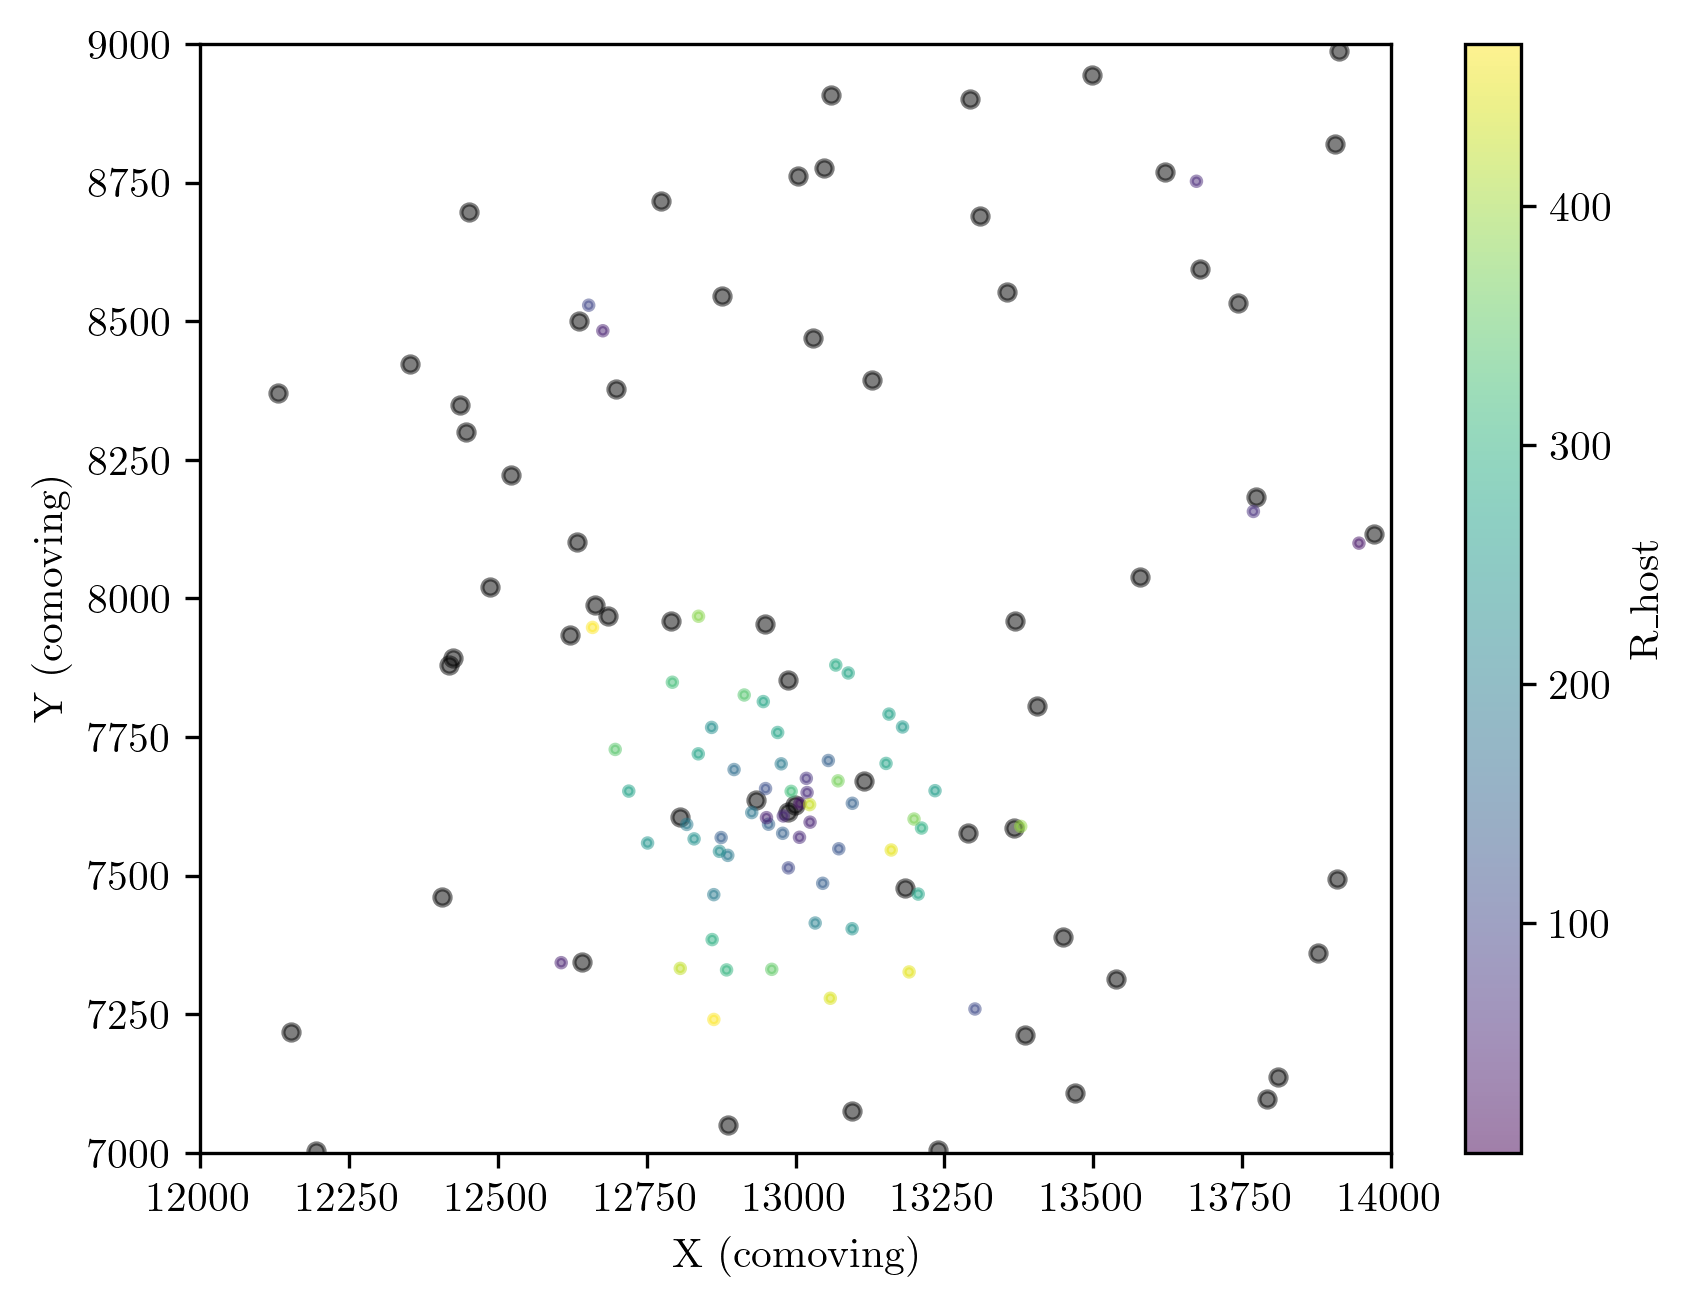

In [14]:
%matplotlib inline
fig, ax = plt.subplots()

x, y, z = dat['Xc_ahf_cat'], dat['Yc_ahf_cat'], dat['Zc_ahf_cat']

ax.scatter(hosts(y), hosts(z),  alpha=0.5, s=15, color='black')

colors = sates((dat['prox_to_host']))
_mappable = ax.scatter(sates(y), sates(z),  alpha=0.5, s=5, c=colors)
fig.colorbar(_mappable, label='R_{host}')
ax.set_xlim((12000, 14000))
ax.set_ylim((7000, 9000))
ax.set_xlabel('X (comoving)')
ax.set_ylabel('Y (comoving)')
fig.savefig('out.png')

crs = mplcursors.cursor(ax)

crs.connect("add", lambda sel: sel.annotation.set_text(
    'Point {},{}'.format(sel.target[0], sel.target[1])))


In [15]:
np.max(sates((prox_to_host)))


467.60530389753967

In [16]:
max(dat['Xc_ahf_cat'])


14998.68392944

In [17]:
# plt.switch_backend('QtAgg')

# fig = plt.figure()
# ax = mplot3d.axes3d.Axes3D(fig)

# z = np.linspace(0, 1, 100)
# y = np.sin(z)
# x = np.cos(z)

# ax.scatter3D(x, y, z)
# fig.show()


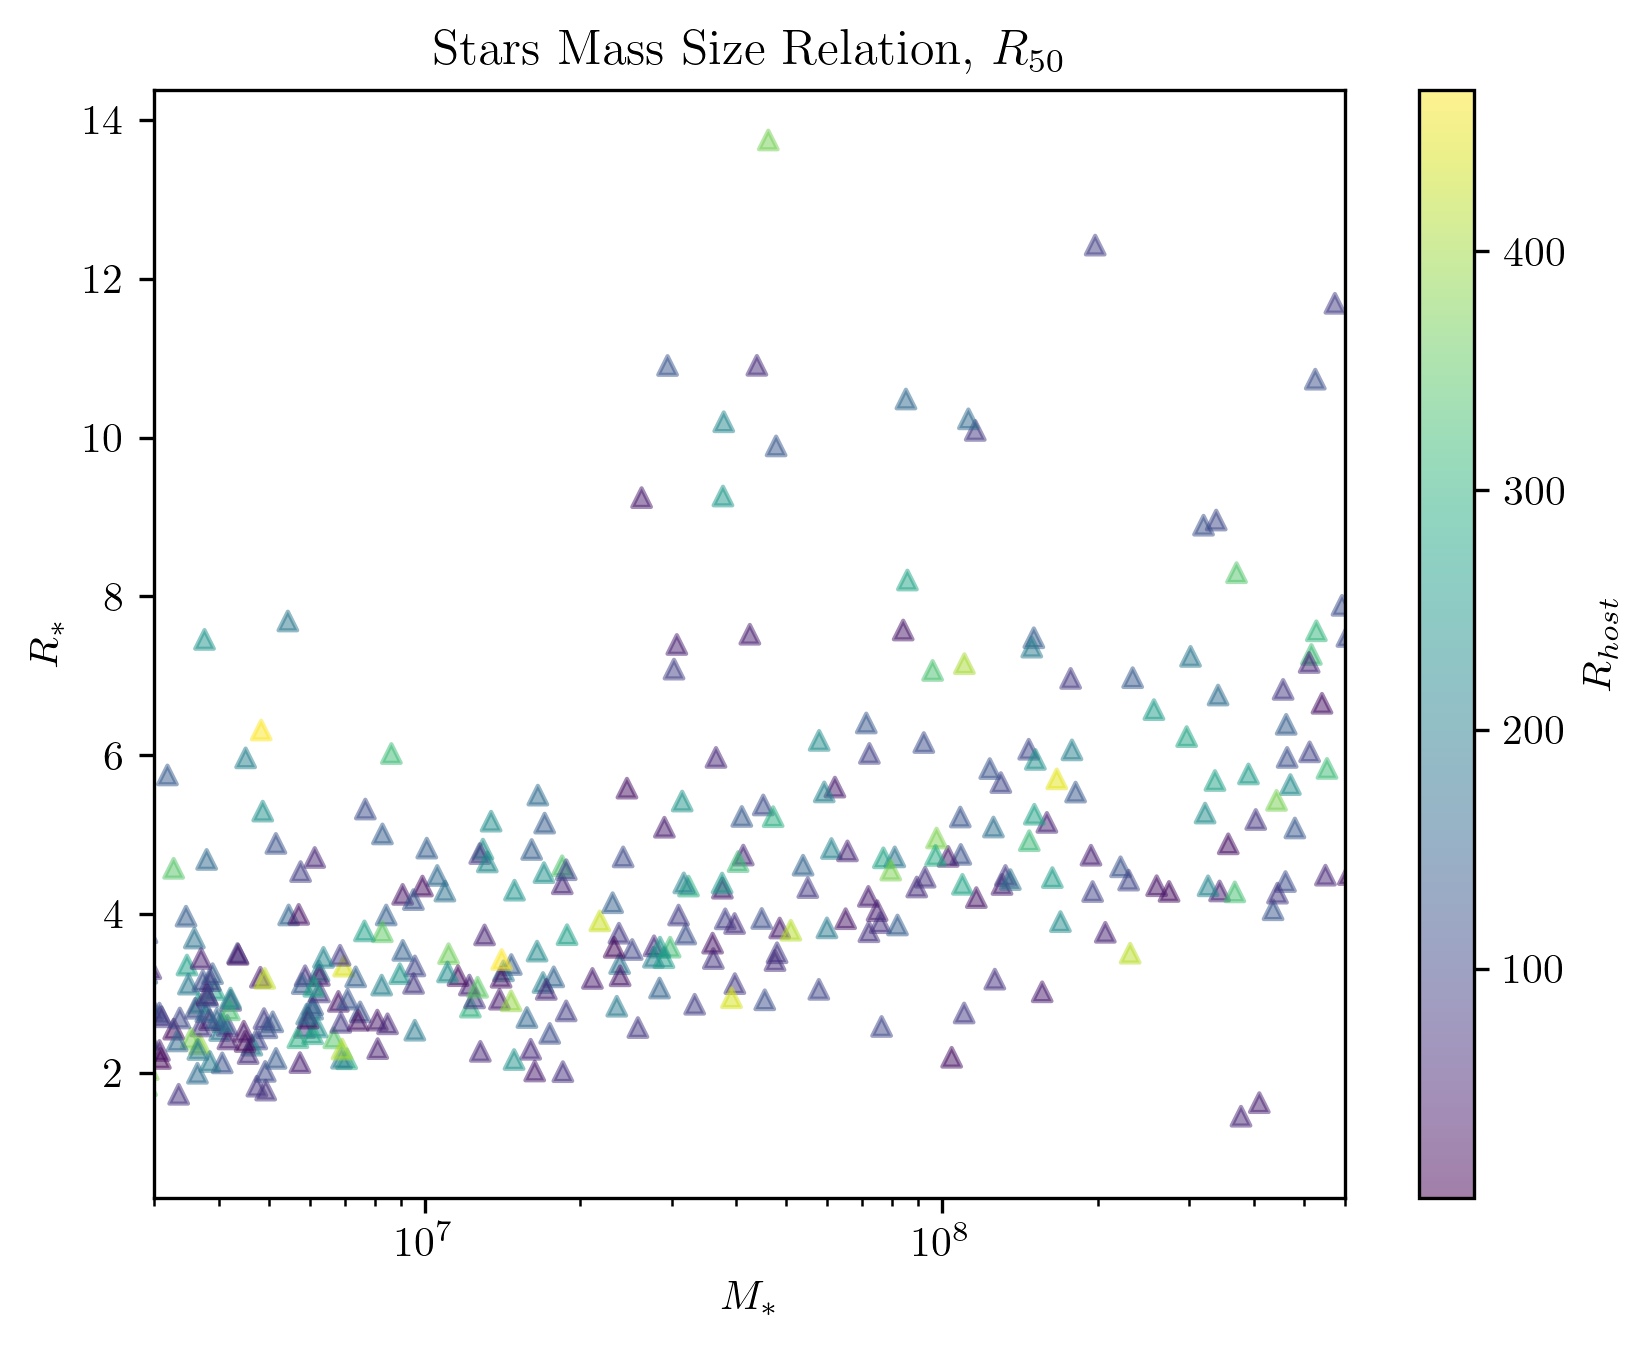

In [18]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
# ax.set_yscale('log')

x, y = dat['stars_mass_within_r50_stars_ahf'], dat['r50_stars_ahf']

#ax.scatter(hosts(x), hosts(y), alpha=0.5, s=10, marker='o', color='black')

colors = sates((dat['prox_to_host']))
_mappable = ax.scatter(sates(x), sates(y), alpha=0.5,
                       s=20, marker='^', c=colors)
cbar = fig.colorbar(_mappable, label=r'$R_{host}$')
ax.set_xlim(3e6, 6e8)
#ax.set_ylim(1e6, 6e9)

#ax.legend(( 'Hosts', 'Satellites'))
ax.set_title(r'Stars Mass Size Relation, $R_{50}$')
ax.set_xlabel(r'$M_{*}$')
ax.set_ylabel(r'$R_{*}$')
fig.savefig('out.png')


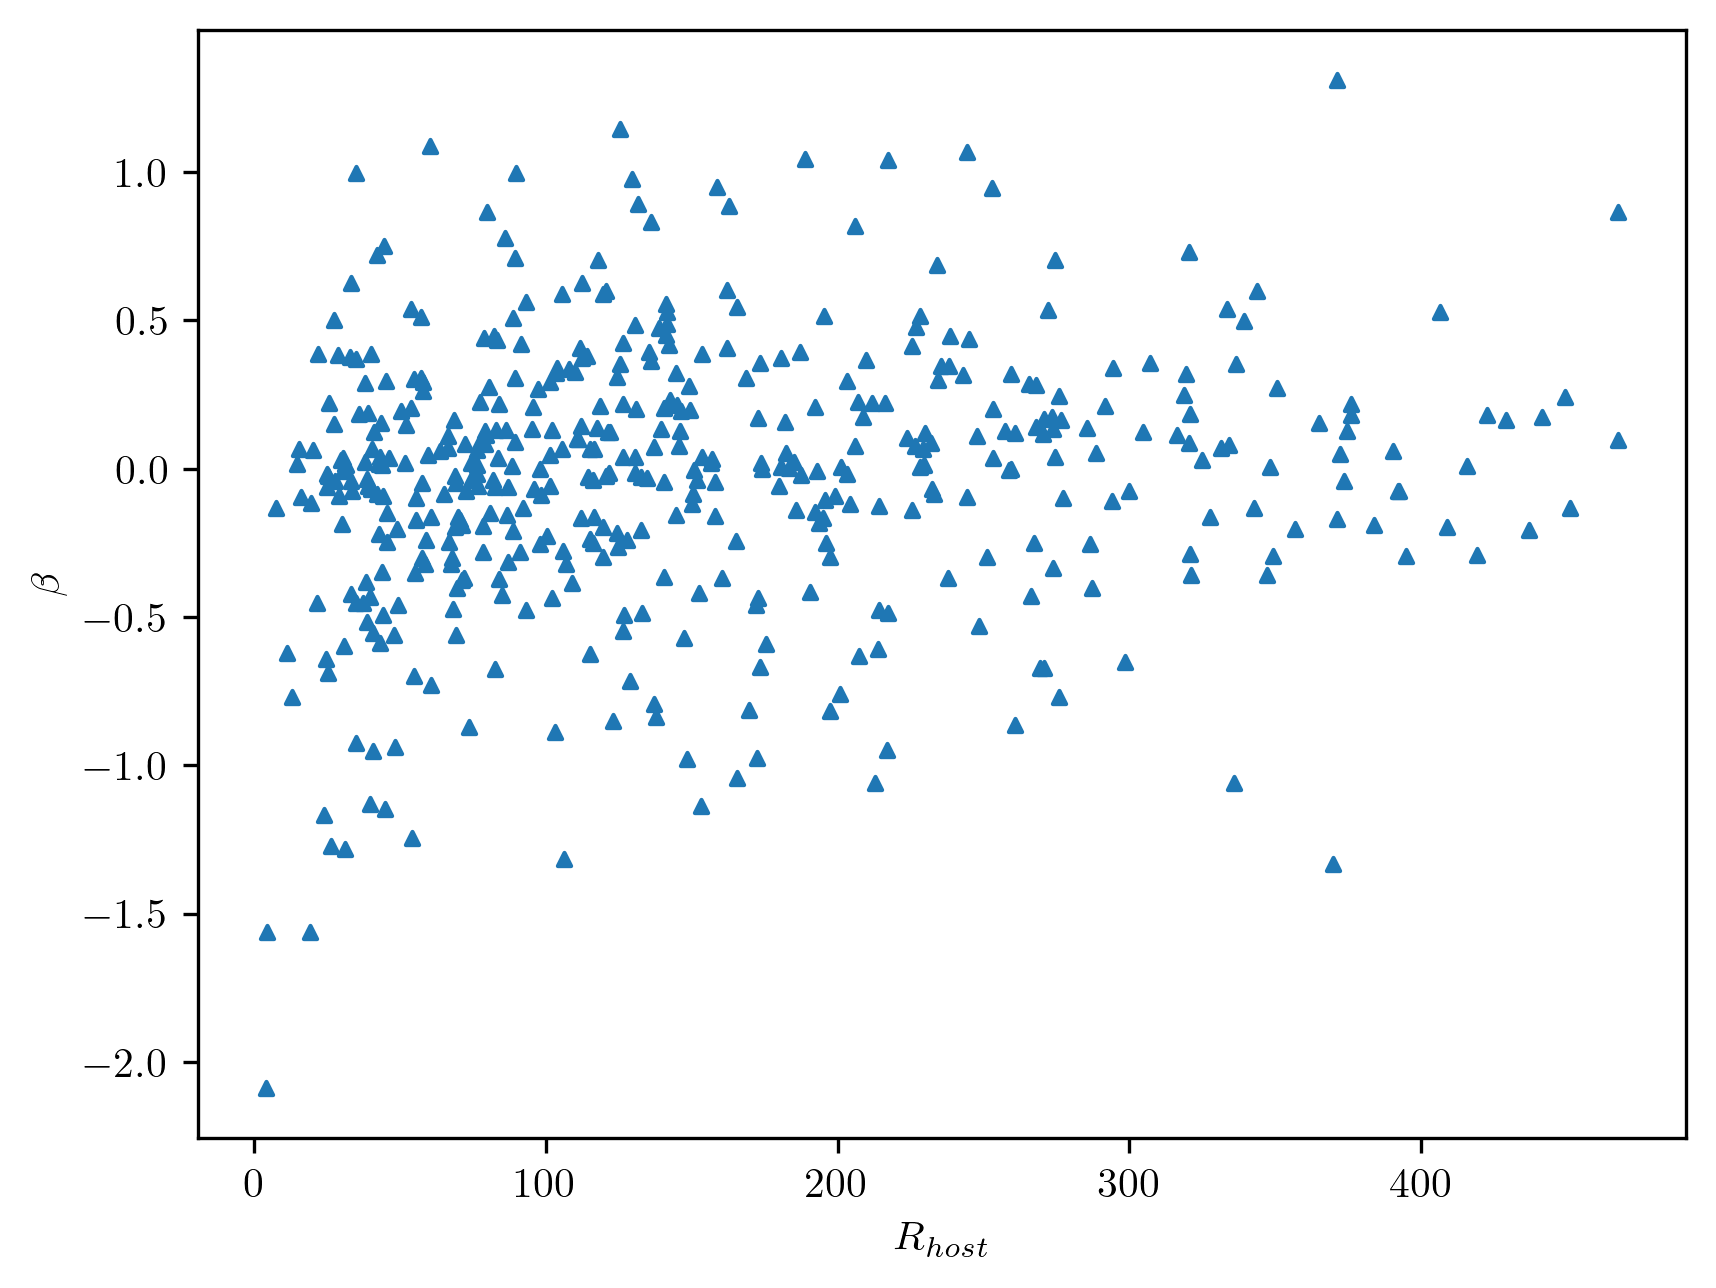

In [19]:
fig, ax = plt.subplots()

ax.scatter(
    dat[s_filt]['prox_to_host'],
    dat[s_filt]['log_power_regression_r50'],
    s=10,
    marker='^'
)

ax.set_xlabel(r'$R_{host}$')
ax.set_ylabel(r'$\beta$')

ax.set_label('Mass-Size Deviation and $R_{host}$')


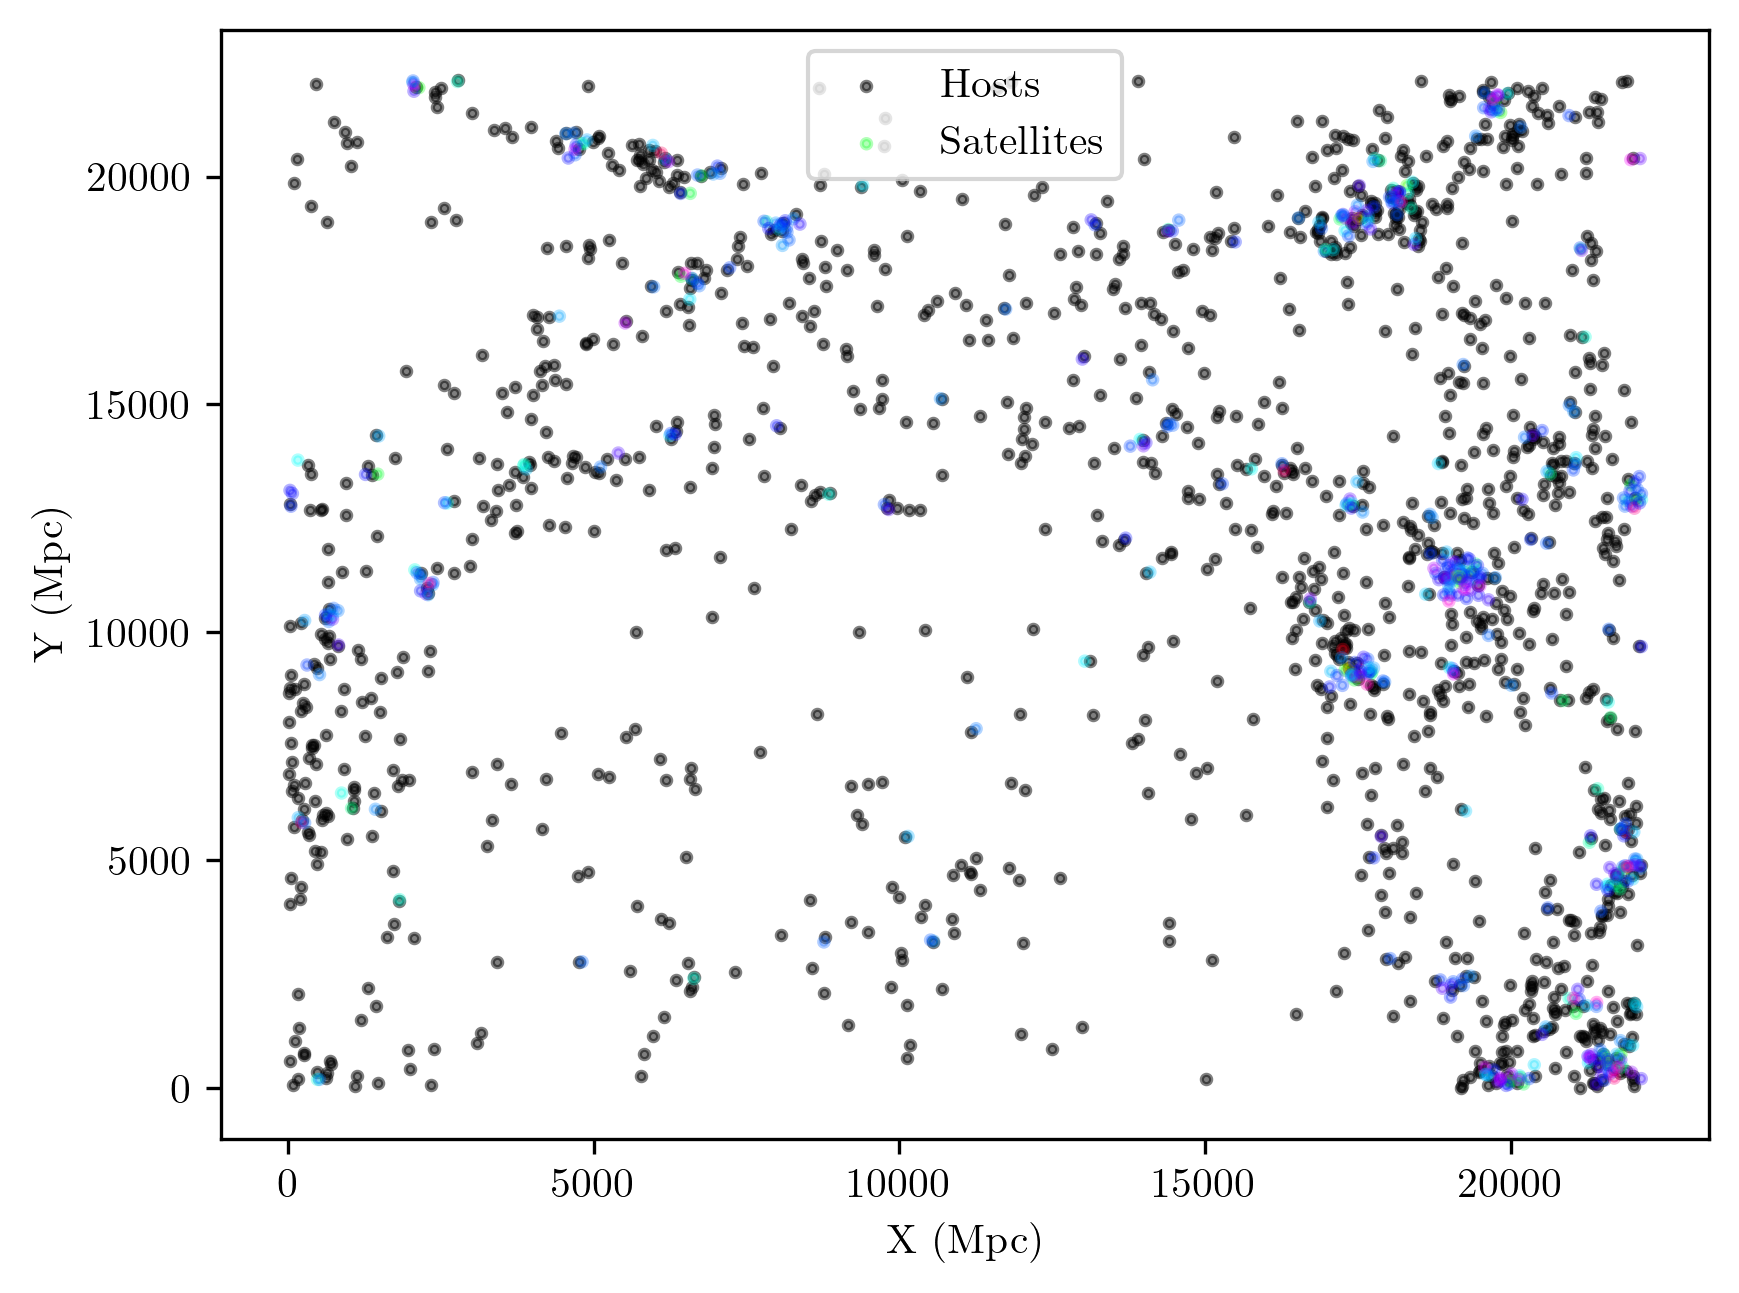

In [22]:
%matplotlib inline
fig, ax = plt.subplots()

x, y, z = dat['X_Mpc_ahf_cat'], dat['Y_Mpc_ahf_cat'], dat['Z_Mpc_ahf_cat']

_size = 5

ax.scatter(hosts(y), hosts(z),  alpha=0.5,
    s=_size,
    color='black')


_mappable = ax.scatter(
    sates(y), sates(z), 
    alpha=0.3,
    s=_size,
    c=sates((dat['log_power_regression_r50'])),
    cmap=CMAP
)

# fig.colorbar(_mappable, label=r'$\beta$')
# ax.set_xlim((0 / h, 15000 / h))
# ax.set_ylim((0 / h, 10000 / h))
ax.set_xlabel('X (Mpc)')
ax.set_ylabel('Y (Mpc)')

ax.legend(('Hosts', 'Satellites'))

fig.savefig('out.png')



In [43]:
# wut

Selection(artist=<matplotlib.collections.PathCollection object at 0x000002A04A9E0BB0>, target_=masked_array(data=[13088.49334717, 7865.40985107],
             mask=[False, False],
       fill_value=1e+20), index=190, dist=2.8271502024123403, annotation=Text(-15, 15, 'x=13088.\ny=7865.\n[275.8]'), extras=[])